# Step1: Import libraries

In [3]:
pip install --upgrade osmnx

Note: you may need to restart the kernel to use updated packages.


In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plotting points

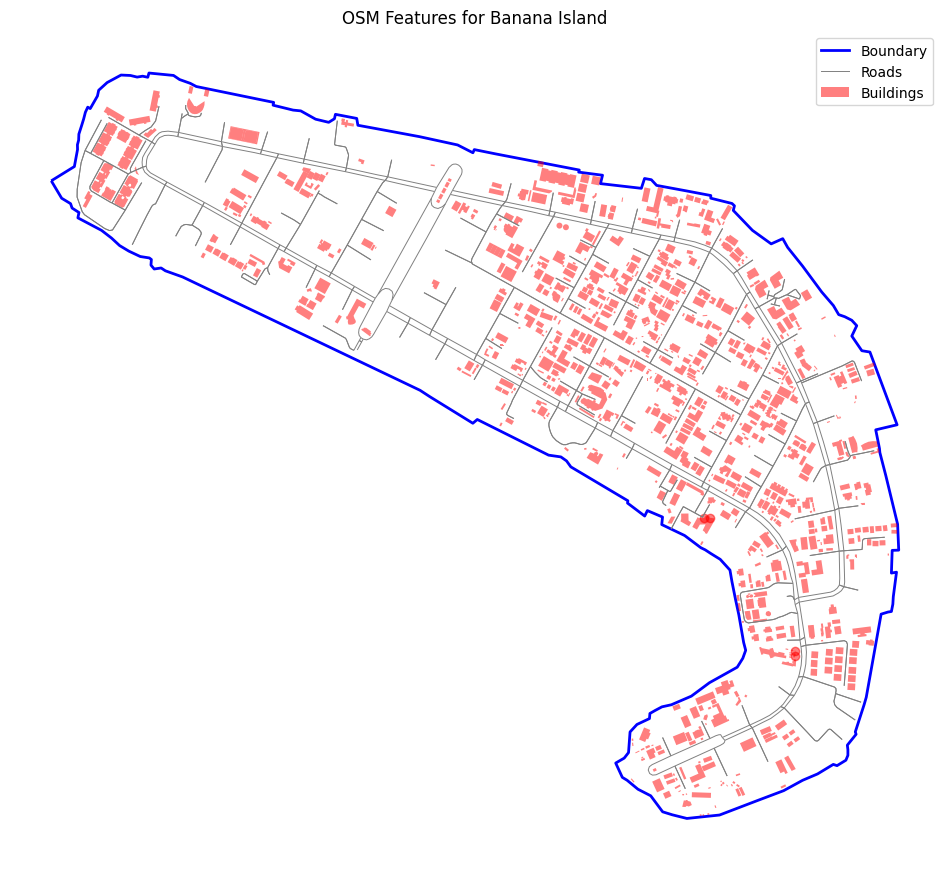

In [32]:
def fetch_banana_island_features():
    # Define the place name
    place_name = "Banana Island, Lagos, Nigeria"

    # Fetch the neighborhood boundary
    boundary = ox.geocode_to_gdf(place_name)

    # Fetch road network within the neighborhood
    roads = ox.graph_from_place(place_name)

    #roads = gpd.read./data/Banana_Island_roads.gpkg"

    # Fetch buildings within the neighborhood
    buildings = ox.features_from_place(place_name, tags={"building": True})

    # Plot all features
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot boundary
    boundary.plot(ax=ax, color="none", edgecolor="blue", linewidth=2, label="Boundary")
    
    # Plot buildings
    buildings.plot(ax=ax, color="red", alpha=0.5)  # Remove legend label for buildings to handle manually

    # Plot roads
    ox.plot_graph(
        roads, ax=ax, show=False, close=False, edge_color="gray", node_size=0, edge_linewidth=0.7
    )

    # Dynamically adjust axis limits to fit the boundary
    bounds = boundary.total_bounds  # Get [minx, miny, maxx, maxy]
    ax.set_xlim(bounds[0] - 0.001, bounds[2] + 0.001)  # Add small buffer to left and right
    ax.set_ylim(bounds[1] - 0.001, bounds[3] + 0.001)  # Add small buffer to top and bottom

    # Add custom legend
    custom_legend = [
        plt.Line2D([0], [0], color="blue", lw=2, label="Boundary"),
        plt.Line2D([0], [0], color="gray", lw=0.7, label="Roads"),
        Patch(facecolor="red", edgecolor="none", alpha=0.5, label="Buildings"),  # Use Patch here
    ]
    ax.legend(handles=custom_legend, loc="upper right")

    # Set title and show plot
    plt.title("OSM Features for Banana Island")
    plt.show()

    # Save the data to disk
    boundary.to_file("banana_island_boundary.geojson", driver="GeoJSON")
    buildings.to_file("banana_island_buildings.geojson", driver="GeoJSON")

if __name__ == "__main__":
    fetch_banana_island_features()

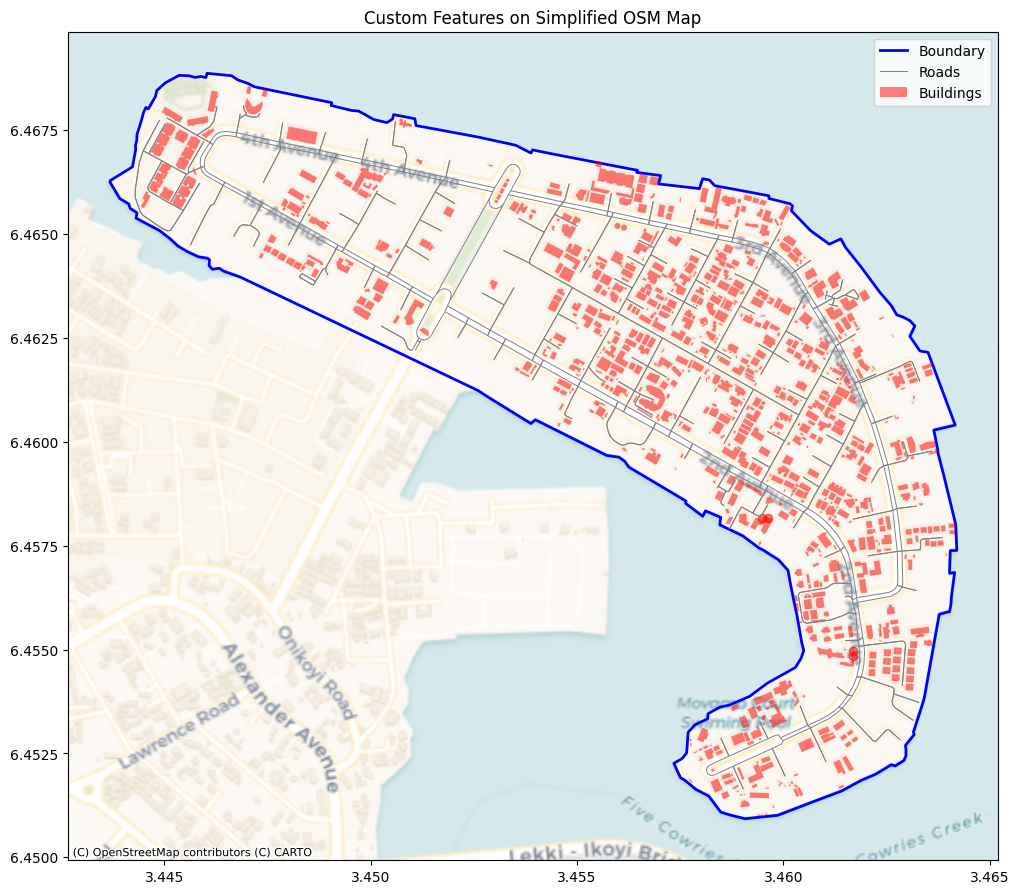

In [37]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.patches import Patch  # Import Patch from matplotlib.patches
import contextily as ctx  # For OSM basemap

def fetch_banana_island_features():
    # Define the place name
    place_name = "Banana Island, Lagos, Nigeria"

    # Fetch the neighborhood boundary
    boundary = ox.geocode_to_gdf(place_name)

    # Fetch road network within the neighborhood
    roads = ox.graph_from_place(place_name, network_type='all', simplify=True)

    # Fetch buildings within the neighborhood
    buildings = ox.features_from_place(place_name, tags={"building": True})

    # Plot all features
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot boundary
    boundary.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=2, label="Boundary")
    
    # Plot buildings
    buildings.plot(ax=ax, color="red", alpha=0.5, label="Buildings")  

    # Convert the roads graph to GeoDataFrame for compatibility with contextily
    edges = ox.graph_to_gdfs(roads, nodes=False)

    # Plot roads
    edges.plot(ax=ax, color="gray", linewidth=0.7, label="Roads")

    # Add simplified basemap
    ctx.add_basemap(
        ax,
        crs=boundary.crs.to_string(),
        source=ctx.providers.CartoDB.Voyager # Minimalistic basemap without detailed roads/buildings
    )

    # Dynamically adjust axis limits to fit the boundary
    bounds = boundary.total_bounds  # [minx, miny, maxx, maxy]
    ax.set_xlim(bounds[0] - 0.001, bounds[2] + 0.001)  # Add small buffer to left and right
    ax.set_ylim(bounds[1] - 0.001, bounds[3] + 0.001)  # Add small buffer to top and bottom

    # Add custom legend
    custom_legend = [
        plt.Line2D([0], [0], color="blue", lw=2, label="Boundary"),
        plt.Line2D([0], [0], color="gray", lw=0.7, label="Roads"),
        Patch(facecolor="red", edgecolor="none", alpha=0.5, label="Buildings"),
    ]
    ax.legend(handles=custom_legend, loc="upper right")

    # Set title and show plot
    plt.title("Custom Features on Simplified OSM Map")
    plt.show()

    # Save the data to disk
    boundary.to_file("banana_island_boundary.geojson", driver="GeoJSON")
    buildings.to_file("banana_island_buildings.geojson", driver="GeoJSON")

if __name__ == "__main__":
    fetch_banana_island_features()

In [12]:
help(ox.graph_from_place)

Help on function graph_from_place in module osmnx.graph:

graph_from_place(query: 'str | dict[str, str] | list[str | dict[str, str]]', *, network_type: 'str' = 'all', simplify: 'bool' = True, retain_all: 'bool' = False, truncate_by_edge: 'bool' = False, which_result: 'int | None | list[int | None]' = None, custom_filter: 'str | list[str] | None' = None) -> 'nx.MultiDiGraph'
    Download and create a graph within the boundaries of some place(s).

    The query must be geocodable and OSM must have polygon boundaries for the
    geocode result. If OSM does not have a polygon for this place, you can
    instead get its street network using the `graph_from_address` function,
    which geocodes the place name to a point and gets the network within some
    distance of that point.

    If OSM does have polygon boundaries for this place but you're not finding
    it, try to vary the query string, pass in a structured query dict, or vary
    the `which_result` argument to use a different geocod

# Creating points within 5 minutes from each other in the estate.

In [11]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import random

def randomly_place_points(place_name, min_street_length=55, min_distance_straight_line=403, num_attempts=1000):
    """
    Randomly place points on the road network for roads longer than min_street_length.
    Ensure points are at least min_distance_straight_line apart as the crow flies.

    Args:
        place_name (str): Name of the place to fetch the road network for.
        min_street_length (float): Minimum length of roads to consider (meters).
        min_distance_straight_line (float): Minimum straight-line distance between points (meters).
        num_attempts (int): Maximum number of placement attempts for generating points.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame of the placed points.
    """
    # Fetch the boundary and road network
    print("Fetching data from OpenStreetMap...")
    roads = ox.graph_from_place(place_name, network_type="walk", simplify=True)

    # Convert edges to GeoDataFrame
    edges = ox.graph_to_gdfs(roads, nodes=False)
    edges = edges.to_crs(epsg=3857)  # Reproject to metric CRS for accurate length calculations
    edges["length"] = edges.geometry.length  # Calculate road lengths in meters

    # Filter roads by minimum length
    long_roads = edges[edges["length"] > min_street_length]
    if long_roads.empty:
        print("No roads meet the minimum length requirement.")
        return None

    print(f"Number of roads longer than {min_street_length} meters: {len(long_roads)}")

    # Randomly place points
    points = []
    for _ in range(num_attempts):
        # Randomly select a road
        random_road = long_roads.sample(n=1).iloc[0]
        road_geom = random_road.geometry

        # Generate a random point along the road
        random_position = random.uniform(0, 1)
        random_point = road_geom.interpolate(random_position, normalized=True)

        # Check if the new point is far enough from existing points
        if not any(random_point.distance(existing_point) < min_distance_straight_line for existing_point in points):
            points.append(Point(random_point.coords[0]))

    # Create GeoDataFrame of points
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=edges.crs)
    output_file = "random_points_banana_island.geojson"
    points_gdf.to_file(output_file, driver="GeoJSON")
    print(f"Generated {len(points)} points. Saved to {output_file}")
    return points_gdf

if __name__ == "__main__":
    place_name = "Banana Island, Lagos, Nigeria"
    points_gdf = randomly_place_points(place_name)

Fetching data from OpenStreetMap...
Number of roads longer than 55 meters: 424
Generated 10 points. Saved to random_points_banana_island.geojson


# Debugging road network connectivity and fixing CRS

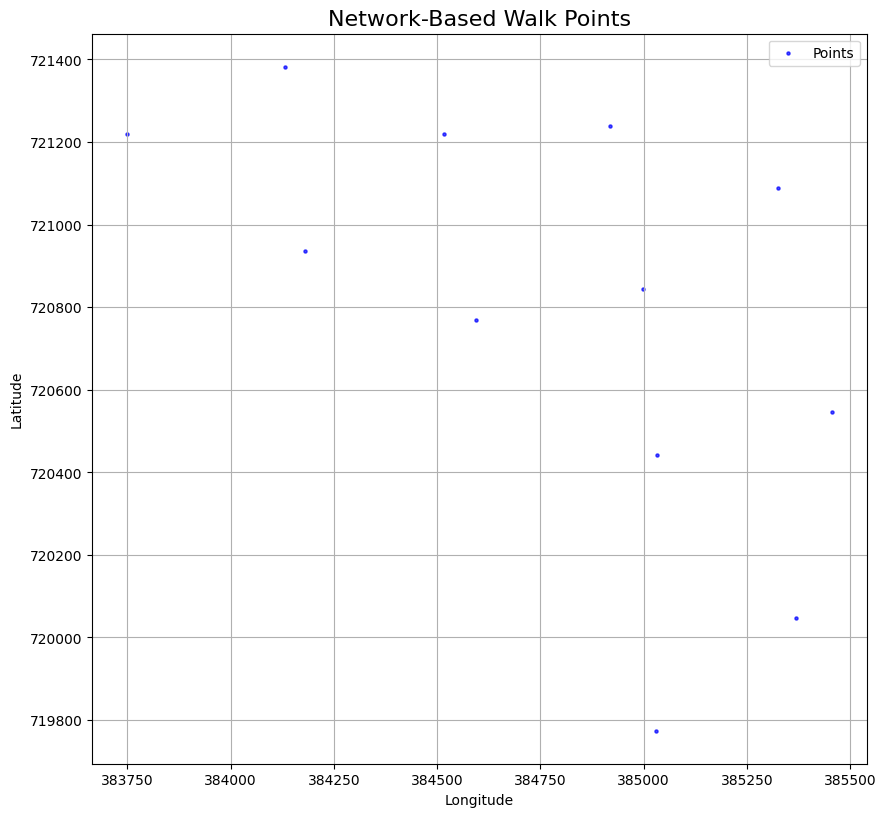

In [116]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
geojson_file = "random_points_banana_island.geojson"
gdf = gpd.read_file(geojson_file)

# Plot the GeoJSON
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="blue", markersize=5, alpha=0.7, label="Points")

# Add labels and grid
ax.set_title("Network-Based Walk Points", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Replotting with points layered on earlier map

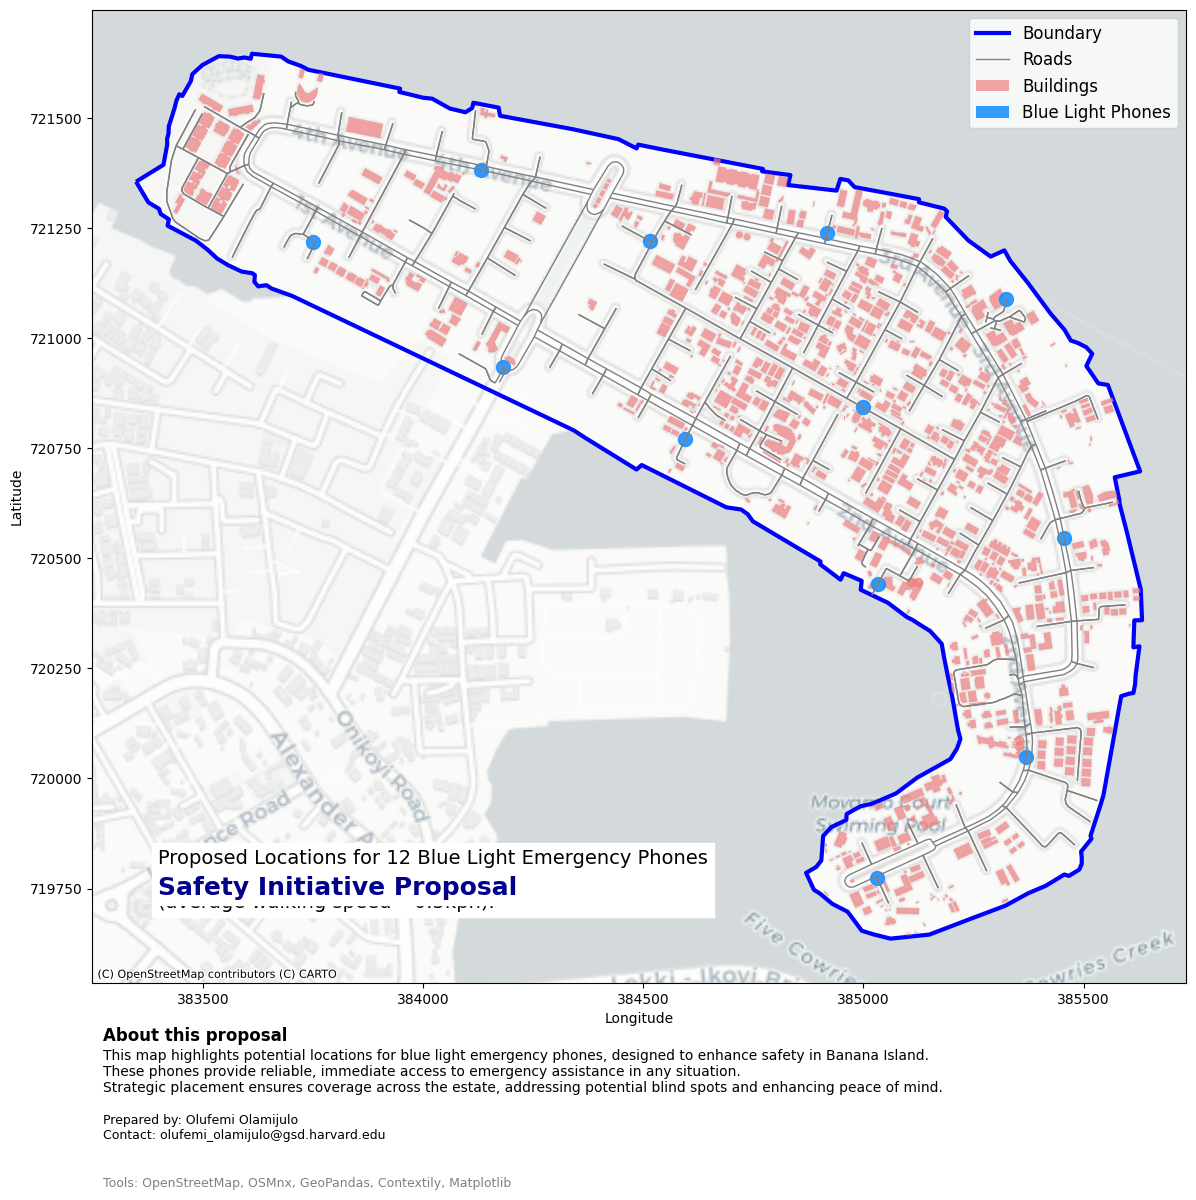

In [23]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as ctx
import geopandas as gpd

def plot_emergency_phone_locations():
    """
    Plot Banana Island features with random points as potential locations for blue light emergency phones.
    """
    # Define the place name
    place_name = "Banana Island, Lagos, Nigeria"

    # Fetch the neighborhood boundary
    boundary = ox.geocode_to_gdf(place_name)

    # Fetch road network within the neighborhood
    roads = ox.graph_from_place(place_name, network_type="all", simplify=True)

    # Fetch buildings within the neighborhood
    buildings = ox.features_from_place(place_name, tags={"building": True})

    # Load the random points GeoJSON
    points_geojson = "random_points_banana_island.geojson"
    points = gpd.read_file(points_geojson)

    # Count the number of points
    num_points = len(points)

    # Ensure CRS consistency (reproject all layers to match the points' CRS)
    target_crs = points.crs
    boundary = boundary.to_crs(target_crs)
    buildings = buildings.to_crs(target_crs)
    edges = ox.graph_to_gdfs(roads, nodes=False).to_crs(target_crs)

    # Plot all features
    fig, ax = plt.subplots(figsize=(16, 12))

    # Plot boundary
    boundary.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=3, label="Boundary")

    # Plot buildings
    buildings.plot(ax=ax, color="lightcoral", alpha=0.7, label="Buildings")

    # Plot roads
    edges.plot(ax=ax, color="gray", linewidth=1, label="Roads")

    # Plot points
    points.plot(ax=ax, color="dodgerblue", markersize=100, alpha=0.9, label="Blue Light Phones")

    # Add basemap
    ctx.add_basemap(
        ax,
        crs=target_crs.to_string(),
        source=ctx.providers.CartoDB.Positron  # Subtle basemap for clarity
    )

    # Adjust axis limits to fit the boundary
    bounds = boundary.total_bounds  # [minx, miny, maxx, maxy]
    ax.set_xlim(bounds[0] - 100, bounds[2] + 100)  # Add small buffer to left and right
    ax.set_ylim(bounds[1] - 100, bounds[3] + 100)  # Add small buffer to top and bottom

    # Add custom legend
    custom_legend = [
        plt.Line2D([0], [0], color="blue", lw=3, label="Boundary"),
        plt.Line2D([0], [0], color="gray", lw=1, label="Roads"),
        Patch(facecolor="lightcoral", edgecolor="none", alpha=0.7, label="Buildings"),
        Patch(facecolor="dodgerblue", edgecolor="none", alpha=0.9, label="Blue Light Phones"),
    ]
    ax.legend(handles=custom_legend, loc="upper right", fontsize=12)

    # Overlay heading and subheading on the map
    ax.text(
        bounds[0] + 50,
        bounds[1] + 100,
        "Safety Initiative Proposal",
        fontsize=18,
        fontweight="bold",
        color="darkblue",
        ha="left",
        backgroundcolor="white",
        zorder=10,# Adds a background to ensure text visibility
    )

    ax.text(
        bounds[0] + 50,
        bounds[1] + 70,
        f"Proposed Locations for {num_points} Blue Light Emergency Phones\n"
        "Spaced for ~5-minute walking time\n"
        "(average walking speed ~0.5kph).",
        fontsize=14,
        color="black",
        ha="left",
        backgroundcolor="white",  # Adds a background to ensure text visibility
    )

    # Add description title
    ax.text(
        0.01,
        -0.06,
        "About this proposal",
        fontsize=12,
        fontweight="bold",
        color="black",
        ha="left",
        transform=ax.transAxes,
    )

    # Add description
    ax.text(
        0.01,
        -0.11,
        "This map highlights potential locations for blue light emergency phones, designed to enhance safety in Banana Island.\n"
        "These phones provide reliable, immediate access to emergency assistance in any situation.\n"
        "Strategic placement ensures coverage across the estate, addressing potential blind spots and enhancing peace of mind.",
        fontsize=10,
        color="black",
        ha="left",
        wrap=True,
        transform=ax.transAxes,
    )

    # Align name and contact information to the left
    ax.text(
        0.01,
        -0.16,
        "Prepared by: Olufemi Olamijulo\nContact: olufemi_olamijulo@gsd.harvard.edu",
        fontsize=9,
        color="black",
        ha="left",
        transform=ax.transAxes,
    )

    # Add tools used
    ax.text(
        0.01,
        -0.21,
        "Tools: OpenStreetMap, OSMnx, GeoPandas, Contextily, Matplotlib",
        fontsize=9,
        color="gray",
        ha="left",
        transform=ax.transAxes,
    )

    # Add axes labels
    ax.set_xlabel("Longitude", fontsize=10)
    ax.set_ylabel("Latitude", fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.savefig("banana_island_emergency_phone_locations.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    plot_emergency_phone_locations()


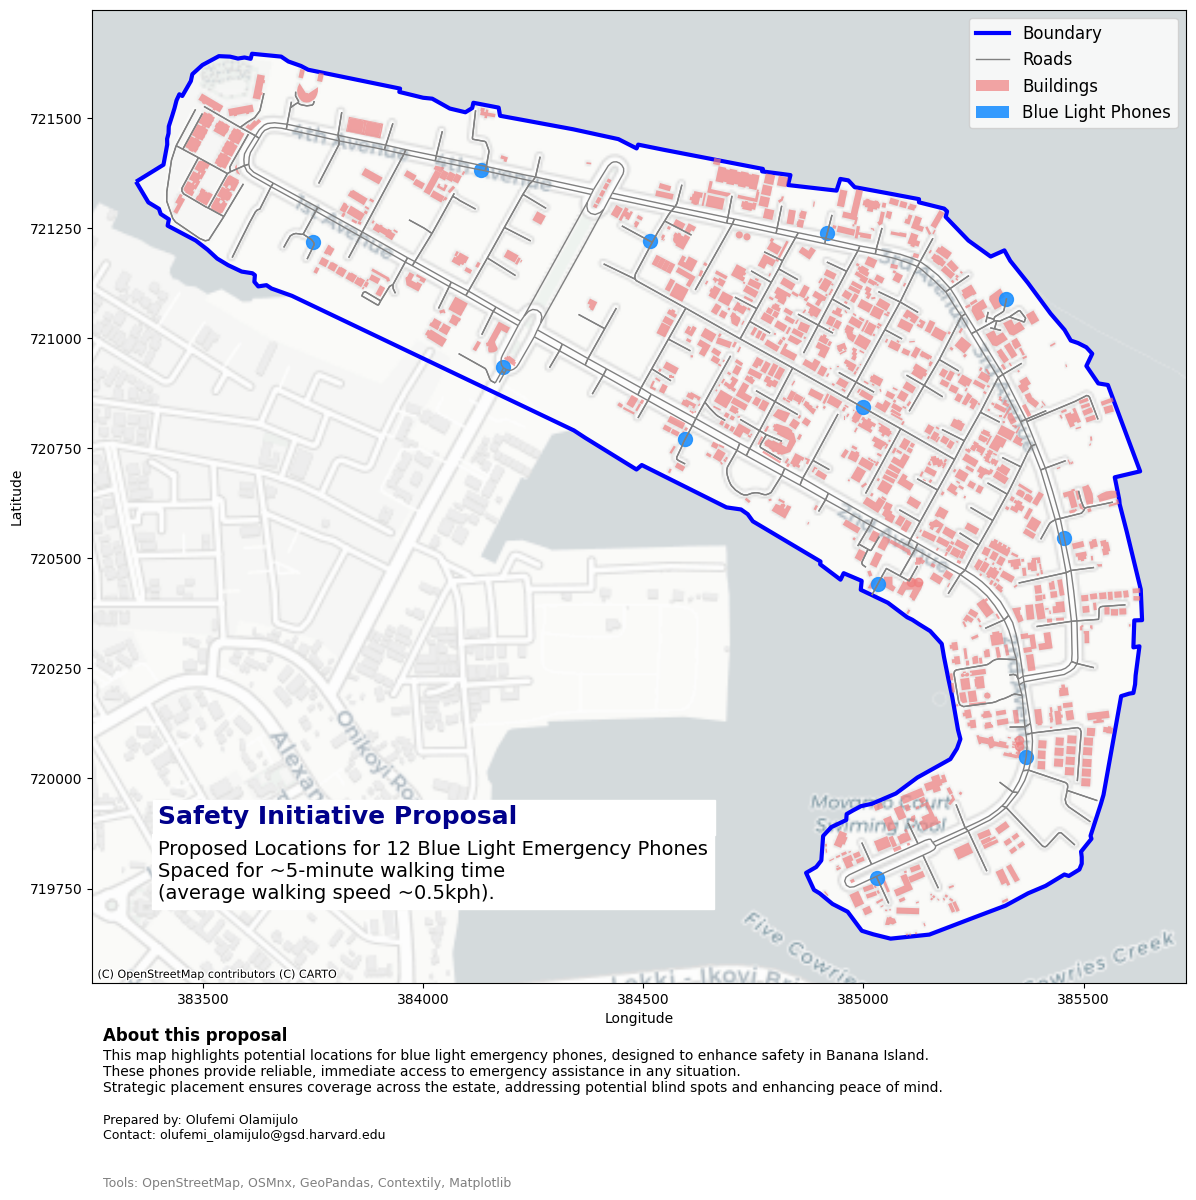

In [32]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as ctx
import geopandas as gpd

def plot_emergency_phone_locations():
    """
    Plot Banana Island features with random points as potential locations for blue light emergency phones.
    """
    # Define the place name
    place_name = "Banana Island, Lagos, Nigeria"

    # Fetch the neighborhood boundary
    boundary = ox.geocode_to_gdf(place_name)

    # Fetch road network within the neighborhood
    roads = ox.graph_from_place(place_name, network_type="all", simplify=True)

    # Fetch buildings within the neighborhood
    buildings = ox.features_from_place(place_name, tags={"building": True})

    # Load the random points GeoJSON
    points_geojson = "random_points_banana_island.geojson"
    points = gpd.read_file(points_geojson)

    # Count the number of points
    num_points = len(points)

    # Ensure CRS consistency (reproject all layers to match the points' CRS)
    target_crs = points.crs
    boundary = boundary.to_crs(target_crs)
    buildings = buildings.to_crs(target_crs)
    edges = ox.graph_to_gdfs(roads, nodes=False).to_crs(target_crs)

    # Plot all features
    fig, ax = plt.subplots(figsize=(16, 12))

    # Plot boundary
    boundary.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=3, label="Boundary")

    # Plot buildings
    buildings.plot(ax=ax, color="lightcoral", alpha=0.7, label="Buildings")

    # Plot roads
    edges.plot(ax=ax, color="gray", linewidth=1, label="Roads")

    # Plot points
    points.plot(ax=ax, color="dodgerblue", markersize=100, alpha=0.9, label="Blue Light Phones")

    # Add basemap
    ctx.add_basemap(
        ax,
        crs=target_crs.to_string(),
        source=ctx.providers.CartoDB.Positron  # Subtle basemap for clarity
    )

    # Adjust axis limits to fit the boundary
    bounds = boundary.total_bounds  # [minx, miny, maxx, maxy]
    ax.set_xlim(bounds[0] - 100, bounds[2] + 100)  # Add small buffer to left and right
    ax.set_ylim(bounds[1] - 100, bounds[3] + 100)  # Add small buffer to top and bottom

    # Add custom legend
    custom_legend = [
        plt.Line2D([0], [0], color="blue", lw=3, label="Boundary"),
        plt.Line2D([0], [0], color="gray", lw=1, label="Roads"),
        Patch(facecolor="lightcoral", edgecolor="none", alpha=0.7, label="Buildings"),
        Patch(facecolor="dodgerblue", edgecolor="none", alpha=0.9, label="Blue Light Phones"),
    ]
    ax.legend(handles=custom_legend, loc="upper right", fontsize=12)

    # Overlay title and subheading on the map
    ax.text(
        bounds[0] + 50,
        bounds[1] + 260,  # Position the title slightly above the subheading
        "Safety Initiative Proposal                      ",
        fontsize=18,
        fontweight="bold",
        color="darkblue",
        ha="left",
        backgroundcolor="white",
        zorder=11,
    )

    ax.text(
        bounds[0] + 50,
        bounds[1] + 90,  # Position the subheading below the title
        f"Proposed Locations for {num_points} Blue Light Emergency Phones\n"
        "Spaced for ~5-minute walking time\n"
        "(average walking speed ~0.5kph).",
        fontsize=14,
        color="black",
        ha="left",
        backgroundcolor="white",
        zorder=10,
    )

    # Add description title
    ax.text(
        0.01,
        -0.06,
        "About this proposal",
        fontsize=12,
        fontweight="bold",
        color="black",
        ha="left",
        transform=ax.transAxes,
    )

    # Add description
    ax.text(
        0.01,
        -0.11,
        "This map highlights potential locations for blue light emergency phones, designed to enhance safety in Banana Island.\n"
        "These phones provide reliable, immediate access to emergency assistance in any situation.\n"
        "Strategic placement ensures coverage across the estate, addressing potential blind spots and enhancing peace of mind.",
        fontsize=10,
        color="black",
        ha="left",
        wrap=True,
        transform=ax.transAxes,
    )

    # Align name and contact information to the left
    ax.text(
        0.01,
        -0.16,
        "Prepared by: Olufemi Olamijulo\nContact: olufemi_olamijulo@gsd.harvard.edu",
        fontsize=9,
        color="black",
        ha="left",
        transform=ax.transAxes,
    )

    # Add tools used
    ax.text(
        0.01,
        -0.21,
        "Tools: OpenStreetMap, OSMnx, GeoPandas, Contextily, Matplotlib",
        fontsize=9,
        color="gray",
        ha="left",
        transform=ax.transAxes,
    )

    # Add axes labels
    ax.set_xlabel("Longitude", fontsize=10)
    ax.set_ylabel("Latitude", fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.savefig("banana_island_emergency_phone_locations.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    plot_emergency_phone_locations()
